# 01. Data Ingestion - NASA Web Server Logs

## Mục tiêu
- Parse raw log files (train.txt, test.txt)
- Aggregate thành time series với 3 granularities (1min, 5min, 15min)
- Xử lý edge cases và missing data (storm gap)
- Lưu processed data dưới dạng parquet

## Dữ liệu
- **train.txt**: 2,934,960 log entries (01/Jul/1995 → 22/Aug/1995)
- **test.txt**: 526,650 log entries (23/Aug/1995 → 31/Aug/1995)

## Log Format (Common Log Format)
```
199.72.81.55 - - [01/Jul/1995:00:00:01 -0400] "GET /history/apollo/ HTTP/1.0" 200 6245
│              │  │                          │                                │    │
│              │  │                          │                                │    └─ Bytes
│              │  │                          │                                └─ Status Code
│              │  │                          └─ Request
│              │  └─ Timestamp + Timezone
│              └─ User (luôn "-")
└─ Host (IP hoặc hostname)
```

In [1]:
# Import libraries
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Thêm src vào path để import modules
sys.path.insert(0, os.path.abspath('..'))

from src.data.parser import NASALogParser, quick_parse
from src.data.preprocessor import LogPreprocessor, load_timeseries, split_train_test

# Config
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
plt.style.use('seaborn-v0_8-whitegrid')

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Định nghĩa paths

In [2]:
# Paths
DATA_DIR = '../DATA'
PROCESSED_DIR = '../data/processed'

TRAIN_FILE = os.path.join(DATA_DIR, 'train.txt')
TEST_FILE = os.path.join(DATA_DIR, 'test.txt')

# Kiểm tra files tồn tại
print(f"Train file: {TRAIN_FILE}")
print(f"  Exists: {os.path.exists(TRAIN_FILE)}")
if os.path.exists(TRAIN_FILE):
    print(f"  Size: {os.path.getsize(TRAIN_FILE) / 1024 / 1024:.2f} MB")

print(f"\nTest file: {TEST_FILE}")
print(f"  Exists: {os.path.exists(TEST_FILE)}")
if os.path.exists(TEST_FILE):
    print(f"  Size: {os.path.getsize(TEST_FILE) / 1024 / 1024:.2f} MB")

Train file: ../DATA\train.txt
  Exists: True
  Size: 304.88 MB

Test file: ../DATA\test.txt
  Exists: True
  Size: 54.20 MB


## 2. Quick Parse - Kiểm tra format dữ liệu

In [3]:
# Parse nhanh 100 dòng đầu để kiểm tra format
print("Kiểm tra format dữ liệu (100 dòng đầu)...")
sample_df = quick_parse(TRAIN_FILE, max_lines=100)

print(f"\nShape: {sample_df.shape}")
print(f"\nData types:")
print(sample_df.dtypes)
print(f"\nSample data:")
sample_df.head(10)

Kiểm tra format dữ liệu (100 dòng đầu)...

Shape: (100, 8)

Data types:
host                   object
timestamp      datetime64[ns]
timezone               object
method                 object
url                    object
protocol               object
status_code             int64
bytes                   int64
dtype: object

Sample data:


,host,timestamp,timezone,method,url,protocol,status_code,bytes
0,199.72.81.55,1995-07-01 00:00:01,-0400,GET,/history/apollo/,HTTP/1.0,200,6245
1,unicomp6.unicomp.net,1995-07-01 00:00:06,-0400,GET,/shuttle/countdown/,HTTP/1.0,200,3985
2,199.120.110.21,1995-07-01 00:00:09,-0400,GET,/shuttle/missions/sts-73/mission-sts-73.html,HTTP/1.0,200,4085
3,burger.letters.com,1995-07-01 00:00:11,-0400,GET,/shuttle/countdown/liftoff.html,HTTP/1.0,304,0
4,199.120.110.21,1995-07-01 00:00:11,-0400,GET,/shuttle/missions/sts-73/sts-73-patch-small.gif,HTTP/1.0,200,4179
5,burger.letters.com,1995-07-01 00:00:12,-0400,GET,/images/NASA-logosmall.gif,HTTP/1.0,304,0
6,burger.letters.com,1995-07-01 00:00:12,-0400,GET,/shuttle/countdown/video/livevideo.gif,HTTP/1.0,200,0
7,205.212.115.106,1995-07-01 00:00:12,-0400,GET,/shuttle/countdown/countdown.html,HTTP/1.0,200,3985
8,d104.aa.net,1995-07-01 00:00:13,-0400,GET,/shuttle/countdown/,HTTP/1.0,200,3985
9,129.94.144.152,1995-07-01 00:00:13,-0400,GET,/,HTTP/1.0,200,7074


In [4]:
# Kiểm tra các giá trị unique
print("Phân phối HTTP Methods:")
print(sample_df['method'].value_counts())

print("\nPhân phối Status Codes:")
print(sample_df['status_code'].value_counts())

print("\nTimezone (tất cả nên là -0400 EDT):")
print(sample_df['timezone'].value_counts())

Phân phối HTTP Methods:
method
GET    100
Name: count, dtype: int64

Phân phối Status Codes:
status_code
200    93
304     4
302     2
404     1
Name: count, dtype: int64

Timezone (tất cả nên là -0400 EDT):
timezone
-0400    100
Name: count, dtype: int64


In [5]:
# Kiểm tra bytes field
print("Bytes statistics:")
print(sample_df['bytes'].describe())

print(f"\nSố entries có bytes = 0: {(sample_df['bytes'] == 0).sum()}")

Bytes statistics:
count       100.000000
mean      15043.370000
std       35111.324527
min           0.000000
25%        1204.000000
50%        4035.000000
75%       11899.750000
max      305722.000000
Name: bytes, dtype: float64

Số entries có bytes = 0: 6


## 3. Parse Full Training Data

In [6]:
# Parse toàn bộ training data
print("="*60)
print("PARSING TRAINING DATA")
print("="*60)

parser = NASALogParser()
train_df = parser.parse_file(TRAIN_FILE)

PARSING TRAINING DATA
Đang đếm số dòng trong file...


Tổng số dòng: 2,934,961


Parsing logs:   0%|          | 0/2934961 [00:00<?, ?it/s]

Parsing logs:   1%|          | 26440/2934961 [00:00<00:11, 264383.86it/s]

Parsing logs:   2%|▏         | 53222/2934961 [00:00<00:10, 266392.52it/s]

Parsing logs:   3%|▎         | 79862/2934961 [00:00<00:10, 262124.56it/s]

Parsing logs:   4%|▎         | 107396/2934961 [00:00<00:10, 267285.66it/s]

Parsing logs:   5%|▍         | 134294/2934961 [00:00<00:10, 267887.18it/s]

Parsing logs:   6%|▌         | 163019/2934961 [00:00<00:12, 222802.90it/s]

Parsing logs:   7%|▋         | 191724/2934961 [00:00<00:11, 240915.95it/s]

Parsing logs:   8%|▊         | 220532/2934961 [00:00<00:10, 254456.97it/s]

Parsing logs:   8%|▊         | 249027/2934961 [00:00<00:10, 263324.75it/s]

Parsing logs:   9%|▉         | 277580/2934961 [00:01<00:09, 269834.00it/s]

Parsing logs:  10%|█         | 306698/2934961 [00:01<00:09, 276138.05it/s]

Parsing logs:  11%|█▏        | 334685/2934961 [00:01<00:09, 273879.78it/s]

Parsing logs:  12%|█▏        | 363993/2934961 [00:01<00:09, 279545.69it/s]

Parsing logs:  13%|█▎        | 392144/2934961 [00:01<00:09, 279578.77it/s]

Parsing logs:  14%|█▍        | 420239/2934961 [00:01<00:09, 278000.07it/s]

Parsing logs:  15%|█▌        | 449035/2934961 [00:01<00:08, 280950.90it/s]

Parsing logs:  16%|█▋        | 477394/2934961 [00:01<00:08, 281733.33it/s]

Parsing logs:  17%|█▋        | 506621/2934961 [00:01<00:08, 284872.86it/s]

Parsing logs:  18%|█▊        | 535194/2934961 [00:01<00:08, 285106.92it/s]

Parsing logs:  19%|█▉        | 564220/2934961 [00:02<00:08, 286646.49it/s]

Parsing logs:  20%|██        | 592904/2934961 [00:02<00:08, 285296.45it/s]

Parsing logs:  21%|██        | 621449/2934961 [00:02<00:08, 279674.23it/s]

Parsing logs:  22%|██▏       | 649449/2934961 [00:02<00:08, 275184.93it/s]

Parsing logs:  23%|██▎       | 677000/2934961 [00:02<00:08, 274149.91it/s]

Parsing logs:  24%|██▍       | 705503/2934961 [00:02<00:08, 277347.16it/s]

Parsing logs:  25%|██▍       | 733259/2934961 [00:02<00:07, 277167.77it/s]

Parsing logs:  26%|██▌       | 760991/2934961 [00:02<00:07, 275892.59it/s]

Parsing logs:  27%|██▋       | 789871/2934961 [00:02<00:07, 279722.29it/s]

Parsing logs:  28%|██▊       | 817855/2934961 [00:02<00:07, 278182.37it/s]

Parsing logs:  29%|██▉       | 845683/2934961 [00:03<00:07, 277606.48it/s]

Parsing logs:  30%|██▉       | 873450/2934961 [00:03<00:07, 276349.09it/s]

Parsing logs:  31%|███       | 901090/2934961 [00:03<00:07, 271668.16it/s]

Parsing logs:  32%|███▏      | 928275/2934961 [00:03<00:07, 267500.28it/s]

Parsing logs:  33%|███▎      | 956697/2934961 [00:03<00:07, 272394.08it/s]

Parsing logs:  34%|███▎      | 985198/2934961 [00:03<00:07, 276113.69it/s]

Parsing logs:  35%|███▍      | 1014876/2934961 [00:03<00:06, 282237.74it/s]

Parsing logs:  36%|███▌      | 1043905/2934961 [00:03<00:06, 284630.39it/s]

Parsing logs:  37%|███▋      | 1072387/2934961 [00:03<00:06, 283812.92it/s]

Parsing logs:  38%|███▊      | 1100782/2934961 [00:04<00:06, 283489.94it/s]

Parsing logs:  38%|███▊      | 1129141/2934961 [00:04<00:06, 273790.05it/s]

Parsing logs:  39%|███▉      | 1156595/2934961 [00:04<00:06, 273635.92it/s]

Parsing logs:  40%|████      | 1184011/2934961 [00:04<00:06, 269740.35it/s]

Parsing logs:  41%|████▏     | 1211650/2934961 [00:04<00:06, 271684.05it/s]

Parsing logs:  42%|████▏     | 1240608/2934961 [00:04<00:06, 276954.15it/s]

Parsing logs:  43%|████▎     | 1268337/2934961 [00:04<00:06, 267675.67it/s]

Parsing logs:  44%|████▍     | 1296485/2934961 [00:04<00:06, 271679.67it/s]

Parsing logs:  45%|████▌     | 1323724/2934961 [00:04<00:05, 271396.93it/s]

Parsing logs:  46%|████▌     | 1350913/2934961 [00:04<00:05, 265793.03it/s]

Parsing logs:  47%|████▋     | 1377774/2934961 [00:05<00:05, 266613.08it/s]

Parsing logs:  48%|████▊     | 1406109/2934961 [00:05<00:05, 271534.80it/s]

Parsing logs:  49%|████▉     | 1433299/2934961 [00:05<00:05, 268954.72it/s]

Parsing logs:  50%|████▉     | 1462437/2934961 [00:05<00:05, 275552.62it/s]

Parsing logs:  51%|█████     | 1491788/2934961 [00:05<00:05, 280875.21it/s]

Parsing logs:  52%|█████▏    | 1520447/2934961 [00:05<00:05, 282571.57it/s]

Parsing logs:  53%|█████▎    | 1548725/2934961 [00:05<00:04, 282332.44it/s]

Parsing logs:  54%|█████▎    | 1577515/2934961 [00:05<00:04, 283990.81it/s]

Parsing logs:  55%|█████▍    | 1606135/2934961 [00:05<00:04, 284649.00it/s]

Parsing logs:  56%|█████▌    | 1634608/2934961 [00:05<00:04, 281706.68it/s]

Parsing logs:  57%|█████▋    | 1662791/2934961 [00:06<00:04, 277557.44it/s]

Parsing logs:  58%|█████▊    | 1690566/2934961 [00:06<00:04, 275246.00it/s]

Parsing logs:  59%|█████▊    | 1718105/2934961 [00:06<00:04, 272469.22it/s]

Parsing logs:  59%|█████▉    | 1745818/2934961 [00:06<00:04, 273835.72it/s]

Parsing logs:  60%|██████    | 1773213/2934961 [00:06<00:04, 273042.39it/s]

Parsing logs:  61%|██████▏   | 1800525/2934961 [00:06<00:04, 272006.53it/s]

Parsing logs:  62%|██████▏   | 1827731/2934961 [00:06<00:04, 271438.37it/s]

Parsing logs:  63%|██████▎   | 1855647/2934961 [00:06<00:03, 273730.27it/s]

Parsing logs:  64%|██████▍   | 1884700/2934961 [00:06<00:03, 278735.62it/s]

Parsing logs:  65%|██████▌   | 1912815/2934961 [00:06<00:03, 279453.54it/s]

Parsing logs:  66%|██████▌   | 1942315/2934961 [00:07<00:03, 284098.59it/s]

Parsing logs:  67%|██████▋   | 1972220/2934961 [00:07<00:03, 288570.92it/s]

Parsing logs:  68%|██████▊   | 2001793/2934961 [00:07<00:03, 290712.83it/s]

Parsing logs:  69%|██████▉   | 2030868/2934961 [00:07<00:03, 286089.51it/s]

Parsing logs:  70%|███████   | 2059496/2934961 [00:07<00:03, 284884.36it/s]

Parsing logs:  71%|███████   | 2087998/2934961 [00:07<00:03, 282199.17it/s]

Parsing logs:  72%|███████▏  | 2116230/2934961 [00:07<00:02, 274693.43it/s]

Parsing logs:  73%|███████▎  | 2143742/2934961 [00:07<00:03, 263531.54it/s]

Parsing logs:  74%|███████▍  | 2171122/2934961 [00:07<00:02, 266456.07it/s]

Parsing logs:  75%|███████▍  | 2198530/2934961 [00:08<00:02, 268654.26it/s]

Parsing logs:  76%|███████▌  | 2226378/2934961 [00:08<00:02, 271523.79it/s]

Parsing logs:  77%|███████▋  | 2254830/2934961 [00:08<00:02, 275352.89it/s]

Parsing logs:  78%|███████▊  | 2282686/2934961 [00:08<00:02, 276299.14it/s]

Parsing logs:  79%|███████▊  | 2310349/2934961 [00:08<00:02, 263414.88it/s]

Parsing logs:  80%|███████▉  | 2336833/2934961 [00:08<00:02, 261674.84it/s]

Parsing logs:  81%|████████  | 2363097/2934961 [00:08<00:02, 256137.30it/s]

Parsing logs:  81%|████████▏ | 2388788/2934961 [00:08<00:02, 252854.04it/s]

Parsing logs:  82%|████████▏ | 2414126/2934961 [00:08<00:02, 236580.09it/s]

Parsing logs:  83%|████████▎ | 2437991/2934961 [00:08<00:02, 233476.94it/s]

Parsing logs:  84%|████████▍ | 2465018/2934961 [00:09<00:01, 243827.83it/s]

Parsing logs:  85%|████████▍ | 2490907/2934961 [00:09<00:01, 248143.72it/s]

Parsing logs:  86%|████████▌ | 2516861/2934961 [00:09<00:01, 251453.76it/s]

Parsing logs:  87%|████████▋ | 2542213/2934961 [00:09<00:01, 252058.18it/s]

Parsing logs:  87%|████████▋ | 2567493/2934961 [00:09<00:01, 250713.71it/s]

Parsing logs:  88%|████████▊ | 2592617/2934961 [00:09<00:01, 247632.60it/s]

Parsing logs:  89%|████████▉ | 2617422/2934961 [00:09<00:01, 245172.57it/s]

Parsing logs:  90%|█████████ | 2646316/2934961 [00:09<00:01, 258014.32it/s]

Parsing logs:  91%|█████████ | 2673388/2934961 [00:09<00:00, 261767.05it/s]

Parsing logs:  92%|█████████▏| 2701779/2934961 [00:09<00:00, 268336.51it/s]

Parsing logs:  93%|█████████▎| 2728648/2934961 [00:10<00:00, 260305.68it/s]

Parsing logs:  94%|█████████▍| 2756855/2934961 [00:10<00:00, 266592.93it/s]

Parsing logs:  95%|█████████▍| 2784257/2934961 [00:10<00:00, 268777.12it/s]

Parsing logs:  96%|█████████▌| 2811187/2934961 [00:10<00:00, 262374.84it/s]

Parsing logs:  97%|█████████▋| 2837488/2934961 [00:10<00:00, 257070.46it/s]

Parsing logs:  98%|█████████▊| 2863251/2934961 [00:10<00:00, 251993.48it/s]

Parsing logs:  98%|█████████▊| 2888497/2934961 [00:10<00:00, 246845.69it/s]

Parsing logs:  99%|█████████▉| 2914256/2934961 [00:10<00:00, 249934.95it/s]

Parsing logs: 100%|██████████| 2934961/2934961 [00:10<00:00, 269134.52it/s]


KẾT QUẢ PARSING
Tổng số dòng:        2,934,961
Parse thành công:    2,934,949 (100.00%)
Parse thất bại:             12 (0.00%)

Mẫu các dòng lỗi (tối đa 5 dòng đầu):
  Line 691503: klothos.crl.research.digital.com - - [10/Jul/1995:16:45:50 -0400] "" 400 -...
  Line 1421675: firewall.dfw.ibm.com - - [20/Jul/1995:07:34:34 -0400] "1/history/apollo/images/"...
  Line 1422424: firewall.dfw.ibm.com - - [20/Jul/1995:07:53:24 -0400] "1/history/apollo/images/"...
  Line 1454420: 128.159.122.20 - - [20/Jul/1995:15:28:50 -0400] "kÂÃ»txÂÃ»tGÂÃ»tÃÂÃ»" 40...
  Line 1649964: 128.159.122.20 - - [24/Jul/1995:13:52:50 -0400] "kÂÃ»txÂÃ»tGÂÃ»tÃÂÃ»" 40...


In [7]:
# Thống kê parsing
stats = parser.get_stats()
print(f"\nParsing Statistics:")
print(f"  Total lines: {stats['total']:,}")
print(f"  Success: {stats['success']:,} ({stats['success_rate']:.2f}%)")
print(f"  Failed: {stats['failed']:,}")


Parsing Statistics:
  Total lines: 2,934,961
  Success: 2,934,949 (100.00%)
  Failed: 12


In [8]:
# Kiểm tra training data
print(f"\nTraining DataFrame:")
print(f"  Shape: {train_df.shape}")
print(f"  Memory usage: {train_df.memory_usage(deep=True).sum() / 1024 / 1024:.2f} MB")
print(f"  Date range: {train_df['timestamp'].min()} to {train_df['timestamp'].max()}")
print(f"  Duration: {(train_df['timestamp'].max() - train_df['timestamp'].min()).days} days")


Training DataFrame:
  Shape: (2934949, 8)


  Memory usage: 935.23 MB


  Date range: 1995-07-01 00:00:01 to 1995-08-22 23:59:59
  Duration: 52 days


In [9]:
# Sample data
print("\nSample từ training data:")
train_df.head(10)


Sample từ training data:


,host,timestamp,timezone,method,url,protocol,status_code,bytes
0,199.72.81.55,1995-07-01 00:00:01,-0400,GET,/history/apollo/,HTTP/1.0,200,6245
1,unicomp6.unicomp.net,1995-07-01 00:00:06,-0400,GET,/shuttle/countdown/,HTTP/1.0,200,3985
2,199.120.110.21,1995-07-01 00:00:09,-0400,GET,/shuttle/missions/sts-73/mission-sts-73.html,HTTP/1.0,200,4085
3,burger.letters.com,1995-07-01 00:00:11,-0400,GET,/shuttle/countdown/liftoff.html,HTTP/1.0,304,0
4,199.120.110.21,1995-07-01 00:00:11,-0400,GET,/shuttle/missions/sts-73/sts-73-patch-small.gif,HTTP/1.0,200,4179
5,burger.letters.com,1995-07-01 00:00:12,-0400,GET,/images/NASA-logosmall.gif,HTTP/1.0,304,0
6,burger.letters.com,1995-07-01 00:00:12,-0400,GET,/shuttle/countdown/video/livevideo.gif,HTTP/1.0,200,0
7,205.212.115.106,1995-07-01 00:00:12,-0400,GET,/shuttle/countdown/countdown.html,HTTP/1.0,200,3985
8,d104.aa.net,1995-07-01 00:00:13,-0400,GET,/shuttle/countdown/,HTTP/1.0,200,3985
9,129.94.144.152,1995-07-01 00:00:13,-0400,GET,/,HTTP/1.0,200,7074


## 4. Parse Test Data

In [10]:
# Parse test data
print("="*60)
print("PARSING TEST DATA")
print("="*60)

parser_test = NASALogParser()
test_df = parser_test.parse_file(TEST_FILE)

PARSING TEST DATA
Đang đếm số dòng trong file...
Tổng số dòng: 526,651


Parsing logs:   0%|          | 0/526651 [00:00<?, ?it/s]

Parsing logs:   5%|▌         | 28173/526651 [00:00<00:01, 281687.29it/s]

Parsing logs:  11%|█         | 58175/526651 [00:00<00:01, 292462.93it/s]

Parsing logs:  17%|█▋        | 88496/526651 [00:00<00:01, 297366.28it/s]

Parsing logs:  23%|██▎       | 120034/526651 [00:00<00:01, 304472.59it/s]

Parsing logs:  29%|██▊       | 151289/526651 [00:00<00:01, 307382.46it/s]

Parsing logs:  35%|███▍      | 182028/526651 [00:00<00:01, 306514.52it/s]

Parsing logs:  40%|████      | 213229/526651 [00:00<00:01, 308303.44it/s]

Parsing logs:  46%|████▋     | 244665/526651 [00:00<00:00, 310224.87it/s]

Parsing logs:  52%|█████▏    | 276019/526651 [00:00<00:00, 311257.12it/s]

Parsing logs:  58%|█████▊    | 307146/526651 [00:01<00:00, 310817.65it/s]

Parsing logs:  64%|██████▍   | 339164/526651 [00:01<00:00, 313676.48it/s]

Parsing logs:  70%|███████   | 370623/526651 [00:01<00:00, 313949.87it/s]

Parsing logs:  76%|███████▋  | 402072/526651 [00:01<00:00, 314109.61it/s]

Parsing logs:  82%|████████▏ | 434123/526651 [00:01<00:00, 316038.32it/s]

Parsing logs:  89%|████████▊ | 466332/526651 [00:01<00:00, 317858.27it/s]

Parsing logs:  95%|█████████▍| 498672/526651 [00:01<00:00, 319521.17it/s]

Parsing logs: 100%|██████████| 526651/526651 [00:01<00:00, 310892.23it/s]


KẾT QUẢ PARSING
Tổng số dòng:          526,651
Parse thành công:      526,646 (100.00%)
Parse thất bại:              5 (0.00%)

Mẫu các dòng lỗi (tối đa 5 dòng đầu):
  Line 394386: 128.159.117.22 - - [30/Aug/1995:13:45:35 -0400] "Ã½ÃÃ­.Â2Ã­.Â>Ã® .Â2Ã¤ÃÃ¥...
  Line 447747: titan - - [31/Aug/1995:05:06:15 -0400] "?" 400 -...
  Line 474034: 163.206.42.13 - - [31/Aug/1995:11:04:42 -0400] "Â|tÂ°9ÃÂ°'ÃÂ|u&Ã·G" ...
  Line 474053: 163.206.42.13 - - [31/Aug/1995:11:04:49 -0400] "Â|tÂ°9ÃÂ°'ÃÂ|u&Ã·G" ...
  Line 496029: 128.159.117.22 - - [31/Aug/1995:14:49:09 -0400] "Ã½ÃÃ­.Â2Ã­.Â>Ã® .Â2Ã¤ÃÃ¥...


In [11]:
# Kiểm tra test data
print(f"\nTest DataFrame:")
print(f"  Shape: {test_df.shape}")
print(f"  Date range: {test_df['timestamp'].min()} to {test_df['timestamp'].max()}")
print(f"  Duration: {(test_df['timestamp'].max() - test_df['timestamp'].min()).days} days")


Test DataFrame:
  Shape: (526646, 8)
  Date range: 1995-08-23 00:00:00 to 1995-08-31 23:59:53
  Duration: 8 days


## 5. Combine và Preprocess

In [12]:
# Combine train và test cho full analysis
full_df = pd.concat([train_df, test_df], ignore_index=True)
full_df = full_df.sort_values('timestamp').reset_index(drop=True)

print(f"Full Dataset:")
print(f"  Total records: {len(full_df):,}")
print(f"  Date range: {full_df['timestamp'].min()} to {full_df['timestamp'].max()}")

Full Dataset:
  Total records: 3,461,595
  Date range: 1995-07-01 00:00:01 to 1995-08-31 23:59:53


In [13]:
# Tạo preprocessor
preprocessor = LogPreprocessor(full_df)

# Lấy data summary
summary = preprocessor.get_data_summary()

print("="*60)
print("DATA SUMMARY")
print("="*60)
print(f"\nTotal Records: {summary['total_records']:,}")
print(f"\nDate Range:")
print(f"  Start: {summary['date_range']['start']}")
print(f"  End: {summary['date_range']['end']}")
print(f"  Duration: {summary['date_range']['duration_days']} days")

print(f"\nRequest Status Breakdown:")
for status, count in summary['requests'].items():
    if status != 'total':
        pct = count / summary['requests']['total'] * 100
        print(f"  {status}: {count:,} ({pct:.2f}%)")

print(f"\nBytes Statistics:")
print(f"  Total: {summary['bytes']['total'] / 1e9:.2f} GB")
print(f"  Mean: {summary['bytes']['mean']:,.0f} bytes")
print(f"  Median: {summary['bytes']['median']:,.0f} bytes")
print(f"  Max: {summary['bytes']['max']:,} bytes")

print(f"\nUnique Hosts (IPs): {summary['unique_hosts']:,}")

print(f"\nHTTP Methods:")
for method, count in summary['methods'].items():
    print(f"  {method}: {count:,}")

print(f"\nStorm Period (Server Offline):")
print(f"  Start: {summary['storm_period']['start']}")
print(f"  End: {summary['storm_period']['end']}")
print(f"  Duration: {summary['storm_period']['duration_hours']:.1f} hours")

DATA SUMMARY

Total Records: 3,461,595

Date Range:
  Start: 1995-07-01 00:00:01
  End: 1995-08-31 23:59:53
  Duration: 61 days

Request Status Breakdown:
  success_2xx: 3,100,521 (89.57%)
  redirect_3xx: 339,843 (9.82%)
  client_error_4xx: 21,125 (0.61%)
  server_error_5xx: 106 (0.00%)

Bytes Statistics:
  Total: 65.52 GB
  Mean: 18,929 bytes
  Median: 3,584 bytes
  Max: 6,823,936 bytes

Unique Hosts (IPs): 137,978

HTTP Methods:
  GET: 3,453,456
  HEAD: 7,917
  POST: 222

Storm Period (Server Offline):
  Start: 1995-08-01 14:52:01
  End: 1995-08-03 04:36:13
  Duration: 37.7 hours


## 6. Detect Gaps trong dữ liệu

In [14]:
# Detect gaps
gaps = preprocessor.detect_gaps(freq='1T', threshold_minutes=30)

print(f"Phát hiện {len(gaps)} gaps > 30 phút:")
if len(gaps) > 0:
    for idx, row in gaps.iterrows():
        storm_marker = " [STORM GAP]" if row['is_storm_gap'] else ""
        print(f"  {row['gap_start']} → {row['gap_end']} ({row['duration_minutes']:.0f} minutes){storm_marker}")

D:\DATA CASE\DATAFLOW\AUTOSCALING ANALYSIS-20260122T034048Z-1-001\AUTOSCALING ANALYSIS\src\data\preprocessor.py:138: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  unique_hosts = df.groupby(pd.Grouper(freq=freq))['host'].nunique()


D:\DATA CASE\DATAFLOW\AUTOSCALING ANALYSIS-20260122T034048Z-1-001\AUTOSCALING ANALYSIS\src\data\preprocessor.py:149: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  ts = df.resample(freq).agg(agg_dict)


Phát hiện 0 gaps > 30 phút:


## 7. Tạo Time Series với nhiều Granularities

In [15]:
# Tạo time series với tất cả granularities
print("="*60)
print("TẠO TIME SERIES")
print("="*60)

granularities = preprocessor.create_all_granularities(fill_gaps=True)

print("\nSummary:")
for name, ts in granularities.items():
    print(f"\n{name}:")
    print(f"  Records: {len(ts):,}")
    print(f"  Date range: {ts.index.min()} to {ts.index.max()}")
    print(f"  Total requests: {ts['request_count'].sum():,}")
    print(f"  Avg requests per window: {ts['request_count'].mean():.2f}")
    print(f"  Max requests per window: {ts['request_count'].max():,}")

TẠO TIME SERIES
Tạo time series với các granularities...
  - Đang xử lý 1min... 

D:\DATA CASE\DATAFLOW\AUTOSCALING ANALYSIS-20260122T034048Z-1-001\AUTOSCALING ANALYSIS\src\data\preprocessor.py:138: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  unique_hosts = df.groupby(pd.Grouper(freq=freq))['host'].nunique()


D:\DATA CASE\DATAFLOW\AUTOSCALING ANALYSIS-20260122T034048Z-1-001\AUTOSCALING ANALYSIS\src\data\preprocessor.py:149: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  ts = df.resample(freq).agg(agg_dict)


D:\DATA CASE\DATAFLOW\AUTOSCALING ANALYSIS-20260122T034048Z-1-001\AUTOSCALING ANALYSIS\src\data\preprocessor.py:180: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_range = pd.date_range(


Done! (89,280 records)
  - Đang xử lý 5min... 

D:\DATA CASE\DATAFLOW\AUTOSCALING ANALYSIS-20260122T034048Z-1-001\AUTOSCALING ANALYSIS\src\data\preprocessor.py:138: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  unique_hosts = df.groupby(pd.Grouper(freq=freq))['host'].nunique()


D:\DATA CASE\DATAFLOW\AUTOSCALING ANALYSIS-20260122T034048Z-1-001\AUTOSCALING ANALYSIS\src\data\preprocessor.py:149: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  ts = df.resample(freq).agg(agg_dict)


D:\DATA CASE\DATAFLOW\AUTOSCALING ANALYSIS-20260122T034048Z-1-001\AUTOSCALING ANALYSIS\src\data\preprocessor.py:180: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_range = pd.date_range(


Done! (17,856 records)
  - Đang xử lý 15min... 

D:\DATA CASE\DATAFLOW\AUTOSCALING ANALYSIS-20260122T034048Z-1-001\AUTOSCALING ANALYSIS\src\data\preprocessor.py:138: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  unique_hosts = df.groupby(pd.Grouper(freq=freq))['host'].nunique()


D:\DATA CASE\DATAFLOW\AUTOSCALING ANALYSIS-20260122T034048Z-1-001\AUTOSCALING ANALYSIS\src\data\preprocessor.py:149: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  ts = df.resample(freq).agg(agg_dict)


Done! (5,952 records)

Summary:

1min:
  Records: 89,280
  Date range: 1995-07-01 00:00:00 to 1995-08-31 23:59:00
  Total requests: 3,461,595
  Avg requests per window: 38.77
  Max requests per window: 405

5min:
  Records: 17,856
  Date range: 1995-07-01 00:00:00 to 1995-08-31 23:55:00
  Total requests: 3,461,595
  Avg requests per window: 193.86
  Max requests per window: 1,501

15min:
  Records: 5,952
  Date range: 1995-07-01 00:00:00 to 1995-08-31 23:45:00
  Total requests: 3,461,595
  Avg requests per window: 581.59
  Max requests per window: 4,212


D:\DATA CASE\DATAFLOW\AUTOSCALING ANALYSIS-20260122T034048Z-1-001\AUTOSCALING ANALYSIS\src\data\preprocessor.py:180: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_range = pd.date_range(


In [16]:
# Xem sample của 1-minute data
print("Sample 1-minute time series:")
granularities['1min'].head(20)

Sample 1-minute time series:


,request_count,bytes_total,bytes_mean,bytes_std,success_count,error_count,server_error_count,unique_hosts,error_rate,avg_request_size,is_storm_period
1995-07-01 00:00:00,42,608453,14486.976190,23271.661239,42,0,0,20,0.000000,14486.976190,0
1995-07-01 00:01:00,61,910128,14920.131148,40859.920874,60,1,0,24,0.016393,14920.131148,0
1995-07-01 00:02:00,57,628556,11027.298246,22569.204255,57,0,0,24,0.000000,11027.298246,0
1995-07-01 00:03:00,71,1747389,24611.112676,79200.908102,71,0,0,26,0.000000,24611.112676,0
1995-07-01 00:04:00,70,1383149,19759.271429,39103.329035,70,0,0,29,0.000000,19759.271429,0
1995-07-01 00:05:00,54,933859,17293.685185,37675.931165,54,0,0,24,0.000000,17293.685185,0
1995-07-01 00:06:00,52,1153891,22190.211538,69366.129635,52,0,0,26,0.000000,22190.211538,0
1995-07-01 00:07:00,68,1157827,17026.867647,31701.505412,68,0,0,23,0.000000,17026.867647,0
1995-07-01 00:08:00,47,1113516,23691.829787,58543.329877,47,0,0,19,0.000000,23691.829787,0
1995-07-01 00:09:00,46,681950,14825.000000,23769.789011,46,0,0,20,0.000000,14825.000000,0


In [17]:
# Xem các cột có sẵn
print("Các cột trong time series:")
for col in granularities['1min'].columns:
    dtype = granularities['1min'][col].dtype
    print(f"  - {col}: {dtype}")

Các cột trong time series:
  - request_count: int64
  - bytes_total: int64
  - bytes_mean: float64
  - bytes_std: float64
  - success_count: int64
  - error_count: int64
  - server_error_count: int64
  - unique_hosts: int64
  - error_rate: float64
  - avg_request_size: float64
  - is_storm_period: int64


## 8. Visualize Traffic Overview

C:\Users\Admin\AppData\Local\Temp\ipykernel_26844\307076974.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  ts_hourly = granularities['1min'].resample('1H').sum()


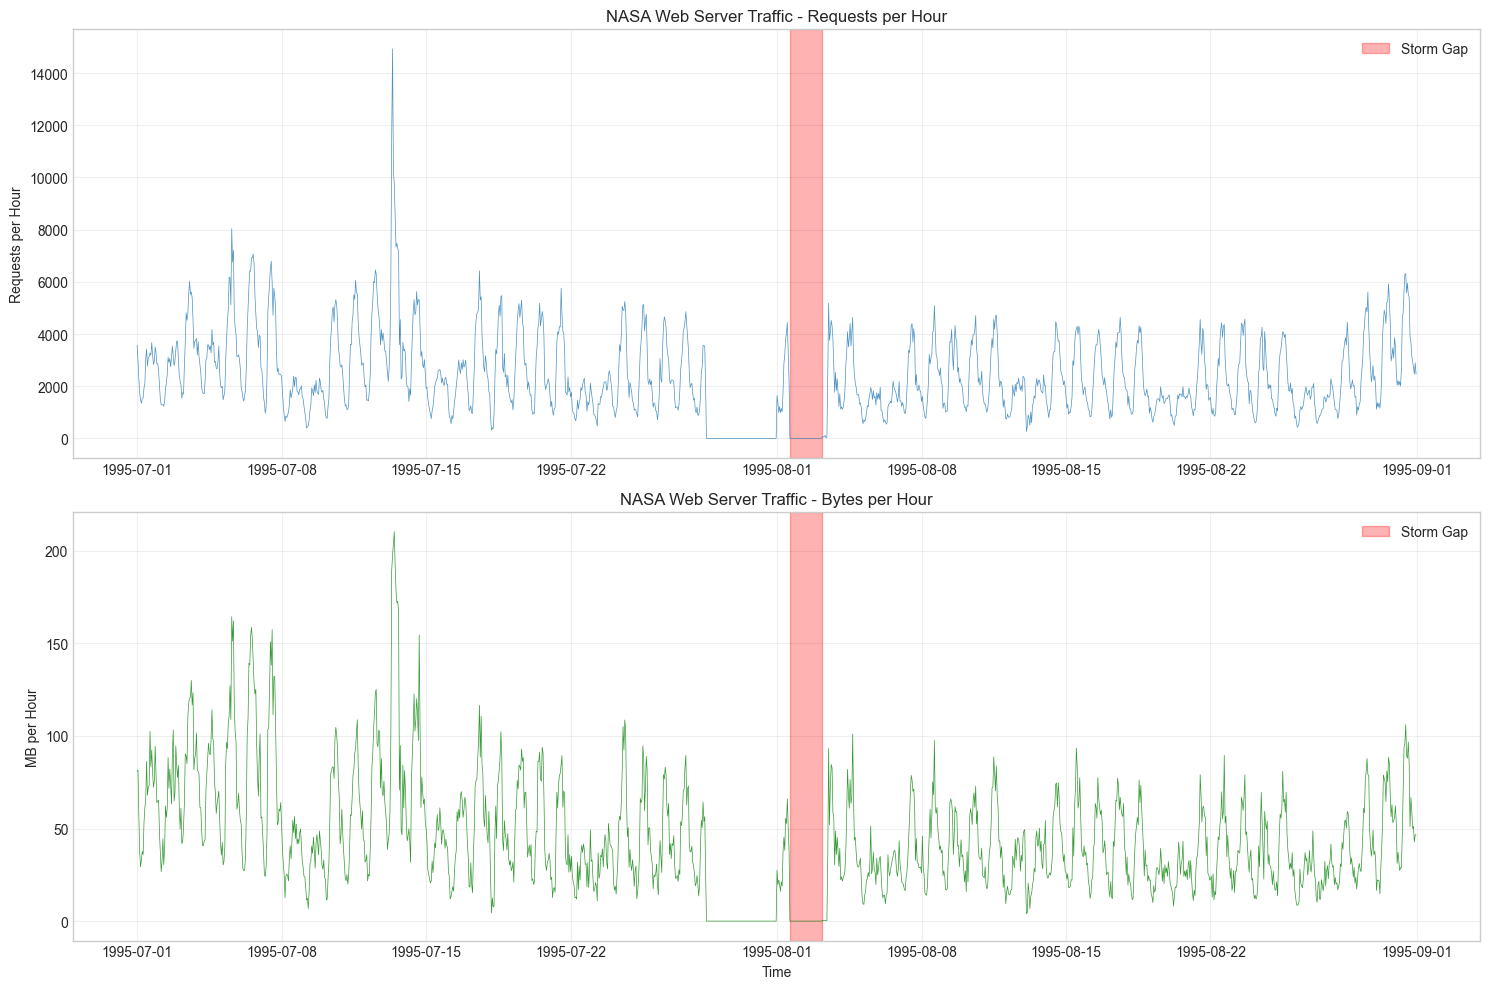

In [18]:
# Plot hourly traffic
ts_hourly = granularities['1min'].resample('1H').sum()

fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Requests per hour
ax1 = axes[0]
ax1.plot(ts_hourly.index, ts_hourly['request_count'], linewidth=0.5, alpha=0.8)
ax1.axvspan(preprocessor.STORM_START, preprocessor.STORM_END, alpha=0.3, color='red', label='Storm Gap')
ax1.set_ylabel('Requests per Hour')
ax1.set_title('NASA Web Server Traffic - Requests per Hour')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Bytes per hour
ax2 = axes[1]
ax2.plot(ts_hourly.index, ts_hourly['bytes_total'] / 1e6, linewidth=0.5, alpha=0.8, color='green')
ax2.axvspan(preprocessor.STORM_START, preprocessor.STORM_END, alpha=0.3, color='red', label='Storm Gap')
ax2.set_ylabel('MB per Hour')
ax2.set_xlabel('Time')
ax2.set_title('NASA Web Server Traffic - Bytes per Hour')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../reports/figures/traffic_overview.png', dpi=150, bbox_inches='tight')
plt.show()

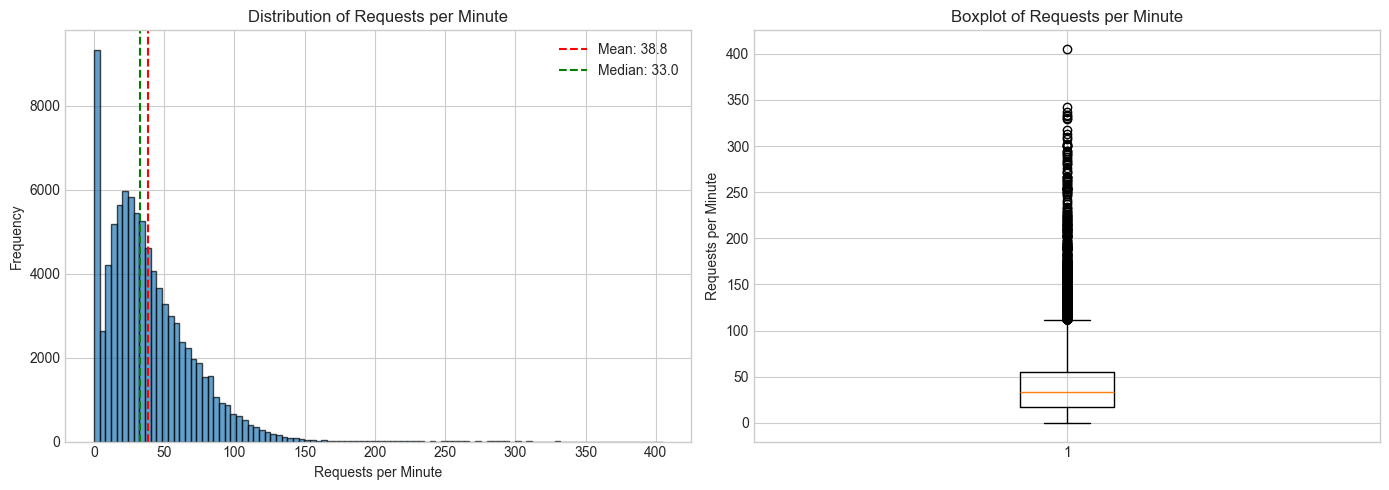

In [19]:
# Distribution của requests per minute
ts_1min = granularities['1min']

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
ax1 = axes[0]
ax1.hist(ts_1min['request_count'], bins=100, edgecolor='black', alpha=0.7)
ax1.set_xlabel('Requests per Minute')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of Requests per Minute')
ax1.axvline(ts_1min['request_count'].mean(), color='red', linestyle='--', label=f"Mean: {ts_1min['request_count'].mean():.1f}")
ax1.axvline(ts_1min['request_count'].median(), color='green', linestyle='--', label=f"Median: {ts_1min['request_count'].median():.1f}")
ax1.legend()

# Boxplot
ax2 = axes[1]
ax2.boxplot(ts_1min['request_count'].dropna(), vert=True)
ax2.set_ylabel('Requests per Minute')
ax2.set_title('Boxplot of Requests per Minute')

plt.tight_layout()
plt.savefig('../reports/figures/requests_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

## 9. Lưu Processed Data

In [20]:
# Tạo thư mục output nếu chưa có
os.makedirs(PROCESSED_DIR, exist_ok=True)
os.makedirs('../reports/figures', exist_ok=True)

# Lưu processed data
print("Đang lưu processed data...")
preprocessor.save_processed(PROCESSED_DIR, granularities)

print("\nDone!")

Đang lưu processed data...


Đã lưu: ../data/processed\timeseries_1min.parquet (89,280 records)
Đã lưu: ../data/processed\timeseries_5min.parquet (17,856 records)
Đã lưu: ../data/processed\timeseries_15min.parquet (5,952 records)

Đã lưu 3 files vào ../data/processed

Done!


In [21]:
# Verify saved files
print("\nKiểm tra files đã lưu:")
for f in os.listdir(PROCESSED_DIR):
    filepath = os.path.join(PROCESSED_DIR, f)
    size_mb = os.path.getsize(filepath) / 1024 / 1024
    print(f"  {f}: {size_mb:.2f} MB")


Kiểm tra files đã lưu:
  timeseries_15min.parquet: 0.31 MB
  timeseries_1min.parquet: 3.77 MB
  timeseries_5min.parquet: 0.83 MB


In [22]:
# Test loading
print("\nTest loading từ parquet:")
ts_loaded = load_timeseries(os.path.join(PROCESSED_DIR, 'timeseries_1min.parquet'))
print(f"  Shape: {ts_loaded.shape}")
print(f"  Index type: {type(ts_loaded.index)}")
print(f"  Date range: {ts_loaded.index.min()} to {ts_loaded.index.max()}")


Test loading từ parquet:


  Shape: (89280, 11)
  Index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
  Date range: 1995-07-01 00:00:00 to 1995-08-31 23:59:00


## 10. Train/Test Split

In [23]:
# Split train/test theo đề bài
# Train: Jul 1995 + Aug 1-22, 1995
# Test: Aug 23-31, 1995

ts_1min = granularities['1min']
train_ts, test_ts = split_train_test(ts_1min, test_start='1995-08-23')

print("Train/Test Split:")
print(f"\nTrain:")
print(f"  Date range: {train_ts.index.min()} to {train_ts.index.max()}")
print(f"  Records: {len(train_ts):,}")
print(f"  Total requests: {train_ts['request_count'].sum():,}")

print(f"\nTest:")
print(f"  Date range: {test_ts.index.min()} to {test_ts.index.max()}")
print(f"  Records: {len(test_ts):,}")
print(f"  Total requests: {test_ts['request_count'].sum():,}")

Train/Test Split:

Train:
  Date range: 1995-07-01 00:00:00 to 1995-08-22 23:59:00
  Records: 76,320
  Total requests: 2,934,949

Test:
  Date range: 1995-08-23 00:00:00 to 1995-08-31 23:59:00
  Records: 12,960
  Total requests: 526,646


## Summary

### Kết quả Data Ingestion:
1. **Parsed thành công** ~3.4 triệu log entries
2. **Tạo time series** với 3 granularities (1min, 5min, 15min)
3. **Xử lý storm gap** (~38 giờ server offline đầu tháng 8)
4. **Lưu** dưới dạng parquet để load nhanh

### Files đã tạo:
- `data/processed/timeseries_1min.parquet`
- `data/processed/timeseries_5min.parquet`
- `data/processed/timeseries_15min.parquet`

### Next Steps:
- Notebook 02: EDA - Phân tích traffic patterns
- Notebook 03: Feature Engineering